**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Neural Network Classifier

We import the libraries and define constants and settings of the notebook:

In [2]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from time import time
from classification_utils import *


pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
RESULTS_DIR = '../data/classification_results'
RANDOM_STATE = 42
clf_name = 'NeuralNetworkClassifier'

We load the data and we count how many examples we have per class in the training data

In [3]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_scaled_indicators_test.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_distance_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

# counting positives and negatives element in the dataseet
pos = (true_labels_train_df['death']==1).sum()
neg = (true_labels_train_df['death']==0).sum()

In [4]:
pos, neg

(28175, 59835)

We display the features names we will use:

In [20]:
print(features_for_clf)
print(f'Number of features: {len(features_for_clf)}')

['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'day_x', 'day_y', 'day_of_week_x', 'day_of_week_y', 'month_x', 'month_y', 'year', 'days_from_first_incident', 'poverty_perc', 'democrat', 'gun_law_rank', 'aggression', 'accidental', 'defensive', 'suicide', 'road', 'house', 'school', 'business', 'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction']
Number of features: 34


here we can see all the features that the classifier will work on, these are all numerical features, some taken from categorical features divided into coordinates of points on a circle

below through the use of two different libraries, keras and scikit learn, we create a neural network and exploit a grid search for the best hiperparameters

In [22]:
# Di seguito uso un wrapper di Keras per usare scikit learn
# fino a poco tempo fa era parte di tensorflow, poi hanno smesso di mantenerlo e infine l'hanno rimosso dalle nuove versioni :(
# https://adriangb.com/scikeras/stable/notebooks/Basic_Usage.html#7.2-Performing-a-grid-search

METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
INITIAL_BIAS = np.log([pos/neg])

def get_clf(meta, hidden_layer_sizes, dropout, final_activation_fun, output_bias):

    output_bias = tf.keras.initializers.Constant(output_bias)
    n_features_in_ = meta["n_features_in_"]
    #n_classes_ = meta["n_classes_"]

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(hidden_layer_size, activation="relu"))
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1, activation=final_activation_fun, bias_initializer=output_bias))
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=6,
    restore_best_weights=True)

clf = KerasClassifier(
    model=get_clf,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # because there is a sigmoid layer
    metrics=METRICS,
    callbacks=[early_stopping],
    validation_split=0.2
)

params = {
    'nn__model__hidden_layer_sizes': [(256, 256, 256, ), (128, 512, 128, ), (128, 128, )],
    'nn__model__dropout': [0.25, 0.5, 0.325],
    'nn__model__output_bias':[0, INITIAL_BIAS],
    'nn__model__final_activation_fun':['sigmoid'],

    'nn__optimizer': ['adamax'],
    'nn__optimizer__learning_rate': [0.001, 0.01, 0.0005],

    'nn__epochs':[125],
    'nn__batch_size':[1024, 2048]
}
params_2 = {
    'nn__model__hidden_layer_sizes': [(128, 512, 128, )],
    'nn__model__dropout': [0.25],
    'nn__model__output_bias':[0],
    'nn__model__final_activation_fun':['sigmoid'],

    'nn__optimizer': ['adamax'],
    'nn__optimizer__learning_rate': [0.001, 0.01],

    'nn__epochs':[250],
    'nn__batch_size':[2048]
}

scaler = MinMaxScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("nn", clf)])

gs = GridSearchCV(pipe, 
                  params, 
                  scoring=make_scorer(f1_score), 
                  n_jobs=-1,
                  verbose=True,
                  cv=StratifiedShuffleSplit(n_splits=2, test_size=1/3, random_state=RANDOM_STATE),
                  refit=False)

gs.fit(indicators_train_df, true_labels_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


c:\Users\Geco\anaconda3\envs\DM_Proj\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=2, random_state=42,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('nn',
                                        KerasClassifier(callbacks=[<keras.src.callbacks.EarlyStopping object at 0x0000025FD7A82AD0>], loss=<keras.src.losses.BinaryCrossentropy object at 0x0000025FA8C6A750>, metrics=[<keras.src.m...
             param_grid={'nn__batch_size': [1024, 2048], 'nn__epochs': [125],
                         'nn__model__dropout': [0.25, 0.5, 0.325],
                         'nn__model__final_activation_fun': ['sigmoid'],
                         'nn__model__hidden_layer_sizes': [(256, 256, 256),
                                                           (128, 512, 128),
                                                           (128, 128)],
                         'nn__model__output_bias': [0, array([-0.75315571])],
                         'nn__optimizer': ['adamax'],
                         'nn__optimizer__learning_rate': [0.001, 0.01, 0.0005]},
             refit=False, scoring=make_scorer(f1_score), verbose=True)

several metrics were used to evaluate the training and outcome of the models considered, and since this is a binary classifier, we chose to use "binary crossentropy" as the loss.

all neural networks tested are constructed as a series of layers that follow one another and are divided into:
- input layer shared by all tested models
- a series of hidden layers and dropout layers, which alternate. After several tests we noticed that 6 total layers is the best compromise between execution time and accuracy of the final classifier
- an output layer that can be initialized with a bias, the first method by which we tried to overcome the problem of unbalanced classes and to try to reduce the training time

In addition to dropout, to adjust complexity, we used the early stopping technique based on loss. The optimizer used is Adam for all models tested.

first we compared different activation functions for the output layer, but sigmoid was the best. Next, with grid search, we optimized other hiperparameters such as neural network structure, learning rate, output unit bias and dropout layer rate

below we can observe the calculated results

In [23]:
val_results_df = pd.DataFrame(gs.cv_results_)
val_results_df.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nn__batch_size,param_nn__epochs,param_nn__model__dropout,param_nn__model__final_activation_fun,param_nn__model__hidden_layer_sizes,param_nn__model__output_bias,param_nn__optimizer,param_nn__optimizer__learning_rate,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,560.428628,2.737197,4.220652,1.847355,1024,125,0.25,sigmoid,"(256, 256, 256)",0,adamax,0.001,"{'nn__batch_size': 1024, 'nn__epochs': 125, 'nn__model__dropout': 0.25, 'nn__model__final_activation_fun': 'sigmoid', 'nn__model__hidden_layer_sizes': (256, 256, 256), 'nn__model__output_bias': 0, 'nn__optimizer': 'adamax', 'nn__optimizer__learning_rate': 0.001}",0.550543,0.549331,0.549937,0.000606,4
1,564.886586,3.717720,2.585228,1.028577,1024,125,0.25,sigmoid,"(256, 256, 256)",0,adamax,0.01,"{'nn__batch_size': 1024, 'nn__epochs': 125, 'nn__model__dropout': 0.25, 'nn__model__final_activation_fun': 'sigmoid', 'nn__model__hidden_layer_sizes': (256, 256, 256), 'nn__model__output_bias': 0, 'nn__optimizer': 'adamax', 'nn__optimizer__learning_rate': 0.01}",0.545508,0.534785,0.540147,0.005362,16


we reorder the grid search results by score obtained in the test. obviously we are still in the validation phase, and the actual test data will be used later for a final evaluation of the chosen model.

In [24]:
params = [col for col in val_results_df.columns if 'param_' in col and 'random' not in col]
val_results_df.sort_values(
    by='mean_test_score',
    ascending=False)[params+['std_test_score', 'mean_test_score', 'rank_test_score']].head(20).style.background_gradient(subset=['std_test_score', 'mean_test_score', 'rank_test_score'], cmap='Blues')

,param_nn__batch_size,param_nn__epochs,param_nn__model__dropout,param_nn__model__final_activation_fun,param_nn__model__hidden_layer_sizes,param_nn__model__output_bias,param_nn__optimizer,param_nn__optimizer__learning_rate,std_test_score,mean_test_score,rank_test_score
18,1024,125,0.500000,sigmoid,"(256, 256, 256)",0,adamax,0.001000,0.009153,0.554365,1
54,2048,125,0.250000,sigmoid,"(256, 256, 256)",0,adamax,0.001000,0.003140,0.550793,2
55,2048,125,0.250000,sigmoid,"(256, 256, 256)",0,adamax,0.010000,0.006416,0.550568,3
0,1024,125,0.250000,sigmoid,"(256, 256, 256)",0,adamax,0.001000,0.000606,0.549937,4
7,1024,125,0.250000,sigmoid,"(128, 512, 128)",0,adamax,0.010000,0.007121,0.548562,5
43,1024,125,0.325000,sigmoid,"(128, 512, 128)",0,adamax,0.010000,0.011085,0.545902,6
36,1024,125,0.325000,sigmoid,"(256, 256, 256)",0,adamax,0.001000,0.000624,0.545337,7
19,1024,125,0.500000,sigmoid,"(256, 256, 256)",0,adamax,0.010000,0.024147,0.544856,8
94,2048,125,0.325000,sigmoid,"(256, 256, 256)",[-0.75315571],adamax,0.010000,0.003320,0.544504,9
100,2048,125,0.325000,sigmoid,"(128, 512, 128)",[-0.75315571],adamax,0.010000,0.013873,0.544402,10


Taking the best model obtained from the grid search we construct the final classifier

In [25]:
best_index = gs.best_index_
best_model_params = val_results_df.iloc[best_index]['params']
# remove from the params the prefix 'nn__'
best_model_params = {k.replace('nn__', ''): v for k, v in best_model_params.items()}
best_model = KerasClassifier(
    model=get_clf,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # because there is a sigmoid layer
    metrics=METRICS,
    callbacks=[early_stopping],
    validation_split=0.2,

    verbose=True,
    **best_model_params
)
print(best_model_params)

{'batch_size': 1024, 'epochs': 125, 'model__dropout': 0.5, 'model__final_activation_fun': 'sigmoid', 'model__hidden_layer_sizes': (256, 256, 256), 'model__output_bias': 0, 'optimizer': 'adamax', 'optimizer__learning_rate': 0.001}


Here we train the chosen classifier again to test its effectiveness. We also perform the predictions on the test set

In [26]:
# scale all the data
minmax_scaler = MinMaxScaler()
indicators_train_scaled = minmax_scaler.fit_transform(indicators_train_df)

# fit the model on all the training data
fit_start = time()
best_model.fit(indicators_train_scaled, true_labels_train)
fit_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_train = best_model.predict(indicators_train_scaled) # TODO: assicurarsi che il 'flattening' automatico sia come vogliamo (tanh è centrata in 0, sigmoid in 0.5)
train_score_time = time()-train_score_start
pred_probas_train = best_model.predict_proba(indicators_train_scaled)

# get the predictions on the test data
test_score_start = time()
pred_labels_test = best_model.predict(indicators_test_df)
test_score_time = time()-test_score_start
pred_probas_test = best_model.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_test, 'probs': pred_probas_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the model
best_model.model_.save(f'{RESULTS_DIR}/{clf_name}.h5')

# save the val results
best_model_val_results = pd.DataFrame(val_results_df.iloc[best_index]).T
best_model_val_results.index = [clf_name]
best_model_val_results.to_csv(f'{RESULTS_DIR}/{clf_name}_train_cv_scores.csv')

Epoch 1/125
69/69 [==============================] - 2s 17ms/step - loss: 0.5968 - cross entropy: 0.5968 - Brier score: 0.2049 - tp: 1495.0000 - fp: 994.0000 - tn: 46871.0000 - fn: 21048.0000 - accuracy: 0.6869 - precision: 0.6006 - recall: 0.0663 - val_loss: 0.5580 - val_cross entropy: 0.5580 - val_Brier score: 0.1889 - val_tp: 2543.0000 - val_fp: 1879.0000 - val_tn: 10091.0000 - val_fn: 3089.0000 - val_accuracy: 0.7178 - val_precision: 0.5751 - val_recall: 0.4515
Epoch 2/125
69/69 [==============================] - 1s 11ms/step - loss: 0.5604 - cross entropy: 0.5604 - Brier score: 0.1896 - tp: 6290.0000 - fp: 3996.0000 - tn: 43869.0000 - fn: 16253.0000 - accuracy: 0.7124 - precision: 0.6115 - recall: 0.2790 - val_loss: 0.5406 - val_cross entropy: 0.5406 - val_Brier score: 0.1819 - val_tp: 2350.0000 - val_fp: 1493.0000 - val_tn: 10477.0000 - val_fn: 3282.0000 - val_accuracy: 0.7287 - val_precision: 0.6115 - val_recall: 0.4173
Epoch 3/125
69/69 [==============================] - 1s 11m

c:\Users\Geco\anaconda3\envs\DM_Proj\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


the description of the final trained model

In [27]:
best_model.model_.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               8960      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

we create a function to be able to display the learning curves for all the metrics defined above

In [28]:
def plot_learning_curve(history, metric_name):
    metric = history[metric_name]
    val_metric = history['val_'+metric_name]
    epochs = range(1, len(metric) + 1)
    plt.plot(epochs, metric, label='Training')
    plt.plot(epochs, val_metric, label='Validation')
    plt.title('Training and validation '+metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

From the graphs below we can observe the training trend. We note that all 125 maximum iterations were performed and that early stopping did not affect the final training. 

In the loss graph we observe a fairly standard curve, we note that the model did not overfit, although from previous tests this could happen if the epoch parameter used was greater than 150. 

The graphs of true positives, true negatve,false positives, and false negatives turn out to be interesting, as we note that during training we have an increase in both true and false negaetives (the class most present in the dataset) and instead a more appropriate behavior for positives, which increase or decrease as expected

finally despite the accuracy suggests a principle of overfitting, which is also confirmed by the precision, the first graph is more reliable because it is more uniform while in the second we notice a large variability between successive epochs regarding the validation value.

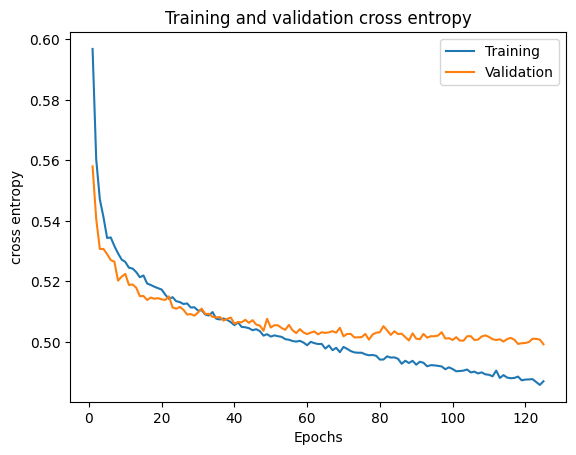

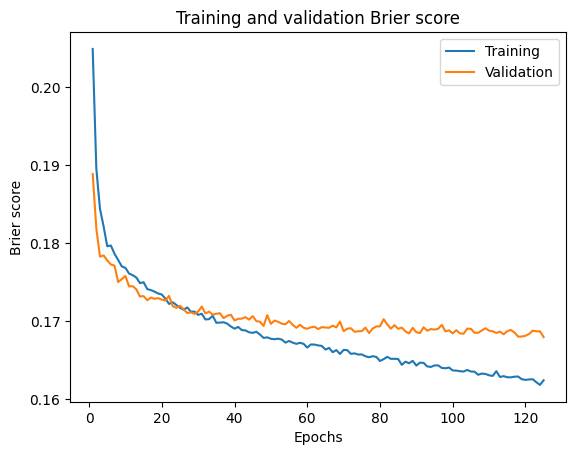

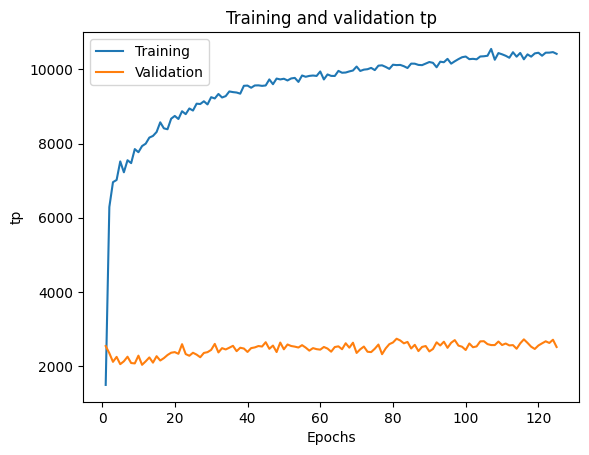

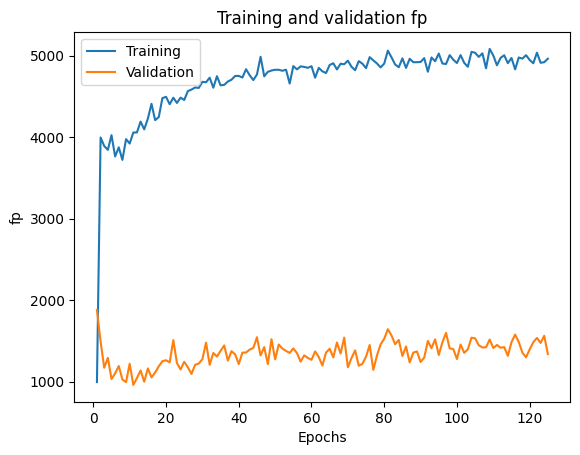

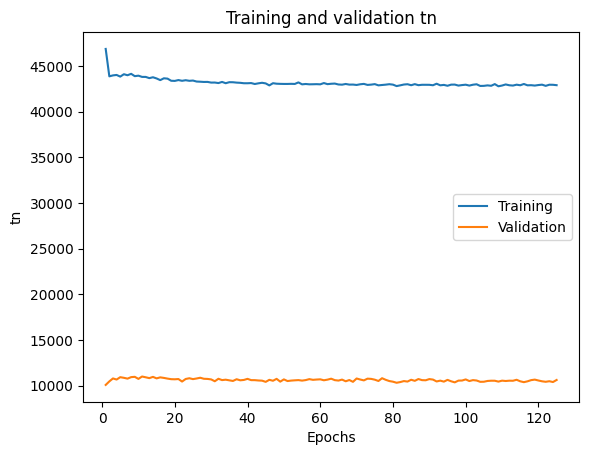

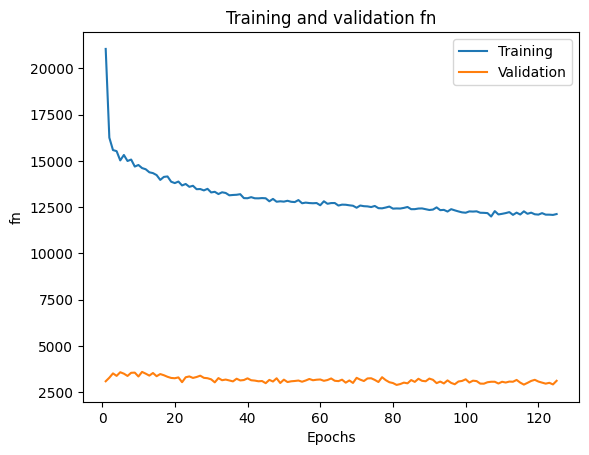

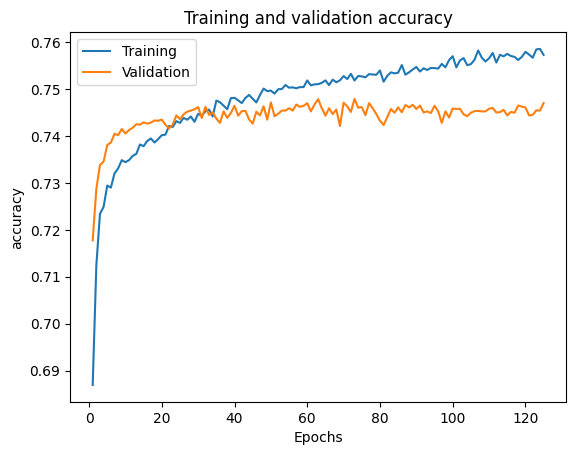

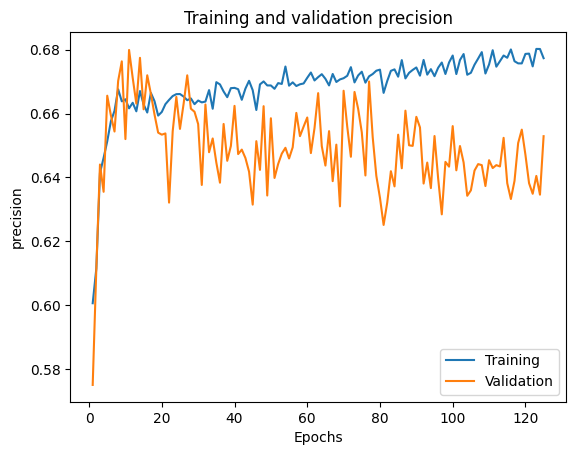

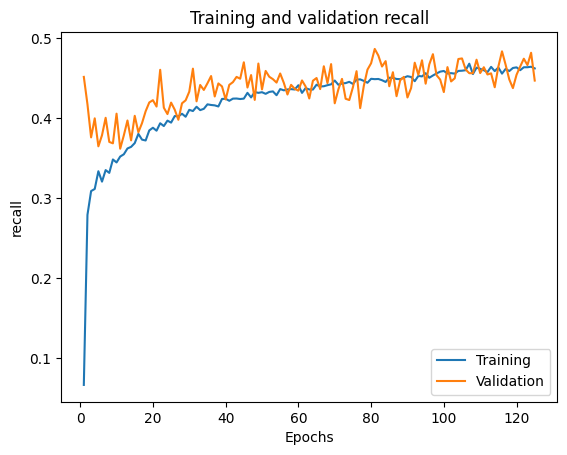

In [29]:
metric_names = ['cross entropy', 'Brier score', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall']
for metric in metric_names:
    plot_learning_curve(best_model.history_, metric)

below we evaluate the final result on validation set and especially on test set

In [31]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=best_model_params,
    prob_pred=pred_probas_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NeuralNetworkClassifier,0.786531,0.896515,0.83793,0.687399,0.483265,0.567534,0.736965,0.68989,0.702732,0.754796,0.76422,0.751367,0.76422,0.811009,102.222364,0.364535,"{'batch_size': 1024, 'epochs': 125, 'model__dropout': 0.5, 'model__final_activation_fun': 'sigmoid', 'model__hidden_layer_sizes': (256, 256, 256), 'model__output_bias': 0, 'optimizer': 'adamax', 'optimizer__learning_rate': 0.001}"


In [32]:
test_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=best_model_params,
    prob_pred=pred_probas_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)
test_scores

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NeuralNetworkClassifier,0.77576,0.889331,0.828672,0.658906,0.454036,0.537615,0.717333,0.671683,0.683143,0.738352,0.749983,0.735498,0.749983,0.791723,102.222364,0.396628,"{'batch_size': 1024, 'epochs': 125, 'model__dropout': 0.5, 'model__final_activation_fun': 'sigmoid', 'model__hidden_layer_sizes': (256, 256, 256), 'model__output_bias': 0, 'optimizer': 'adamax', 'optimizer__learning_rate': 0.001}"


A second srategy we used to overcome the class imbalance problem was to create 2 new training sets, from the original, in which in the first one the least common class was oversampled because it was more influential in the training, in the second... 

In [33]:
indicators_over_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)
indicators_over_train_df = indicators_over_train_df[features_for_clf]
indicators_train_over_scaled = minmax_scaler.fit_transform(indicators_over_train_df)
true_labels_over_train = pd.read_csv('../data/clf_y_train_over.csv', index_col=0).values.ravel()

Below, using the best model found in the initial grid search, we train 2 different classifiers on these 2 new training sets

In [34]:
# fit the model on all the training data
best_model_over = KerasClassifier(
    model=get_clf,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # because there is a sigmoid layer
    metrics=METRICS,
    callbacks=[early_stopping],
    validation_split=0.2,

    verbose=True,
    **best_model_params
)

fit_start = time()
best_model_over.fit(indicators_train_over_scaled, true_labels_over_train)
fit_over_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_over_train = best_model_over.predict(indicators_train_over_scaled)
train_score_over_time = time()-train_score_start
pred_probas_over_train = best_model_over.predict_proba(indicators_train_over_scaled)

# get the predictions on the test data
test_score_start = time()
pred_labels_over_test = best_model_over.predict(indicators_test_df.values)
test_score_over_time = time()-test_score_start
pred_probas_over_test = best_model_over.predict_proba(indicators_test_df.values)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_over_test, 'probs': pred_probas_over_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_oversample_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_oversample.pkl', 'wb')
pickle.dump(obj=best_model_over, file=file)
file.close()

Epoch 1/125
78/78 [==============================] - 3s 17ms/step - loss: 0.6057 - cross entropy: 0.5864 - Brier score: 0.2014 - tp: 3455.0000 - fp: 2334.0000 - tn: 63859.0000 - fn: 27734.0000 - accuracy: 0.6912 - precision: 0.5968 - recall: 0.1108 - val_loss: 0.7627 - val_cross entropy: 0.7627 - val_Brier score: 0.2803 - val_tp: 5339.0000 - val_fp: 603.0000 - val_tn: 5009.0000 - val_fn: 8994.0000 - val_accuracy: 0.5188 - val_precision: 0.8985 - val_recall: 0.3725
Epoch 2/125
78/78 [==============================] - 1s 12ms/step - loss: 0.5628 - cross entropy: 0.5628 - Brier score: 0.1908 - tp: 6494.0000 - fp: 4095.0000 - tn: 50128.0000 - fn: 19063.0000 - accuracy: 0.7097 - precision: 0.6133 - recall: 0.2541 - val_loss: 0.7421 - val_cross entropy: 0.7421 - val_Brier score: 0.2688 - val_tp: 5811.0000 - val_fp: 648.0000 - val_tn: 4964.0000 - val_fn: 8522.0000 - val_accuracy: 0.5402 - val_precision: 0.8997 - val_recall: 0.4054
Epoch 3/125
78/78 [==============================] - 1s 12ms/s

INFO:tensorflow:Assets written to: C:\Users\Geco\AppData\Local\Temp\tmpshyy4aaf\assets


In [35]:
indicators_smote_train_df = pd.read_csv('../data/clf_indicators_train_smote.csv', index_col=0)
indicators_smote_train_df = indicators_smote_train_df[features_for_clf]
indicators_smote_train_scaled = minmax_scaler.fit_transform(indicators_smote_train_df)
true_labels_smote_train = pd.read_csv('../data/clf_y_train_smote.csv', index_col=0).values.ravel()

In [36]:
# fit the model on all the training data
best_model_smote = KerasClassifier(
    model=get_clf,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # because there is a sigmoid layer
    metrics=METRICS,
    callbacks=[early_stopping],
    validation_split=0.2,

    verbose=True,
    **best_model_params
)

fit_start = time()
best_model_smote.fit(indicators_smote_train_scaled, true_labels_smote_train)
fit_smote_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_smote_train = best_model_smote.predict(indicators_smote_train_scaled)
train_score_smote_time = time()-train_score_start
pred_probas_smote_train = best_model_smote.predict_proba(indicators_smote_train_scaled)

# get the predictions on the test data
test_score_start = time()
pred_labels_smote_test = best_model_smote.predict(indicators_test_df.values)
test_score_smote_time = time()-test_score_start
pred_probas_smote_test = best_model_smote.predict_proba(indicators_test_df.values)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_smote_test, 'probs': pred_probas_smote_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_smote_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_smote.pkl', 'wb')
pickle.dump(obj=best_model_smote, file=file)
file.close()

Epoch 1/125
78/78 [==============================] - 3s 17ms/step - loss: 0.6016 - cross entropy: 0.6099 - Brier score: 0.2115 - tp: 8016.0000 - fp: 1461.0000 - tn: 58374.0000 - fn: 31874.0000 - accuracy: 0.6657 - precision: 0.8458 - recall: 0.2010 - val_loss: 0.7074 - val_cross entropy: 0.7074 - val_Brier score: 0.2587 - val_tp: 3134.0000 - val_fp: 228.0000 - val_tn: 5384.0000 - val_fn: 11199.0000 - val_accuracy: 0.4271 - val_precision: 0.9322 - val_recall: 0.2187
Epoch 2/125
78/78 [==============================] - 1s 12ms/step - loss: 0.5586 - cross entropy: 0.5586 - Brier score: 0.1891 - tp: 6563.0000 - fp: 3964.0000 - tn: 50259.0000 - fn: 18994.0000 - accuracy: 0.7122 - precision: 0.6234 - recall: 0.2568 - val_loss: 0.6425 - val_cross entropy: 0.6425 - val_Brier score: 0.2273 - val_tp: 7631.0000 - val_fp: 687.0000 - val_tn: 4925.0000 - val_fn: 6702.0000 - val_accuracy: 0.6295 - val_precision: 0.9174 - val_recall: 0.5324
Epoch 3/125
78/78 [==============================] - 1s 12ms/

INFO:tensorflow:Assets written to: C:\Users\Geco\AppData\Local\Temp\tmp0kgso17z\assets


Below we look at the results of the 3 classifiers created

In [37]:
test_over_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_over_test,
    train_time=fit_over_time,
    score_time=test_score_over_time,
    params=best_model_params,
    prob_pred=pred_probas_over_test,
    clf_name=clf_name+' over',
    path=f'{RESULTS_DIR}/{clf_name}_over_test_scores.csv'
)

test_smote_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    train_time=fit_smote_time,
    score_time=test_score_smote_time,
    params=best_model_params,
    prob_pred=pred_probas_smote_test,
    clf_name=clf_name+' SMOTE',
    path=f'{RESULTS_DIR}/{clf_name}_smote_test_scores.csv'
)

pd.concat([test_scores, test_over_scores, test_smote_scores])

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NeuralNetworkClassifier,0.775760,0.889331,0.828672,0.658906,0.454036,0.537615,0.717333,0.671683,0.683143,0.738352,0.749983,0.735498,0.749983,0.791723,102.222364,0.396628,"{'batch_size': 1024, 'epochs': 125, 'model__dropout': 0.5, 'model__final_activation_fun': 'sigmoid', 'model__hidden_layer_sizes': (256, 256, 256), 'model__output_bias': 0, 'optimizer': 'adamax', 'optimizer__learning_rate': 0.001}"
NeuralNetworkClassifier over,0.781059,0.880473,0.827792,0.652106,0.475829,0.550193,0.716583,0.678151,0.688992,0.739778,0.750937,0.738926,0.750937,0.793357,84.168991,0.213984,"{'batch_size': 1024, 'epochs': 125, 'model__dropout': 0.5, 'model__final_activation_fun': 'sigmoid', 'model__hidden_layer_sizes': (256, 256, 256), 'model__output_bias': 0, 'optimizer': 'adamax', 'optimizer__learning_rate': 0.001}"
NeuralNetworkClassifier SMOTE,0.785360,0.868942,0.825040,0.640374,0.495634,0.558784,0.712867,0.682288,0.691912,0.738947,0.749438,0.739805,0.749438,0.794834,113.034934,0.180999,"{'batch_size': 1024, 'epochs': 125, 'model__dropout': 0.5, 'model__final_activation_fun': 'sigmoid', 'model__hidden_layer_sizes': (256, 256, 256), 'model__output_bias': 0, 'optimizer': 'adamax', 'optimizer__learning_rate': 0.001}"


through the two new training sets, the result achieved turns out to be ever so slightly better than the first, but as effective as the strategy was, the improvement is not too significant.

here we visualize the confusion matrix, on the test set, identical for all three classifiers

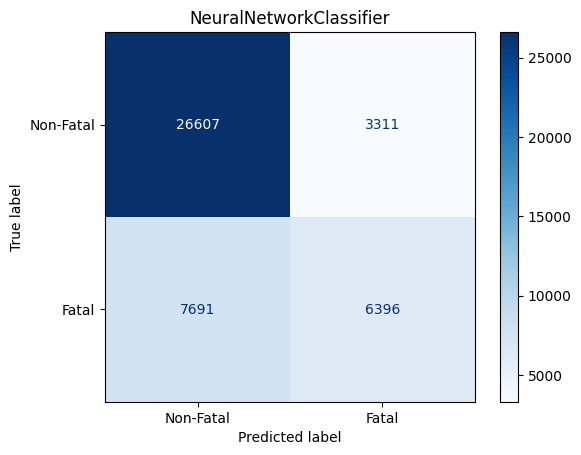

In [38]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    title=clf_name
)

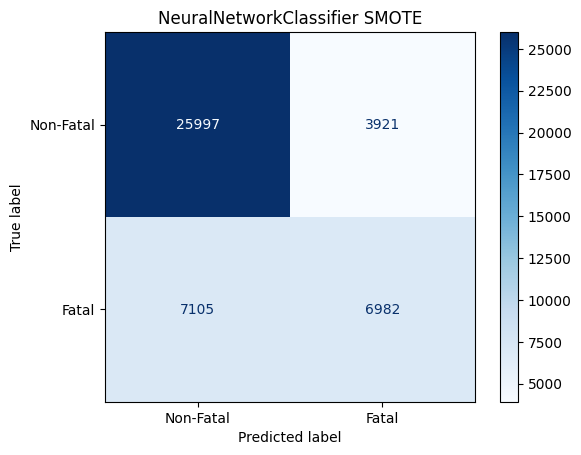

In [39]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    title=clf_name + ' SMOTE'
)

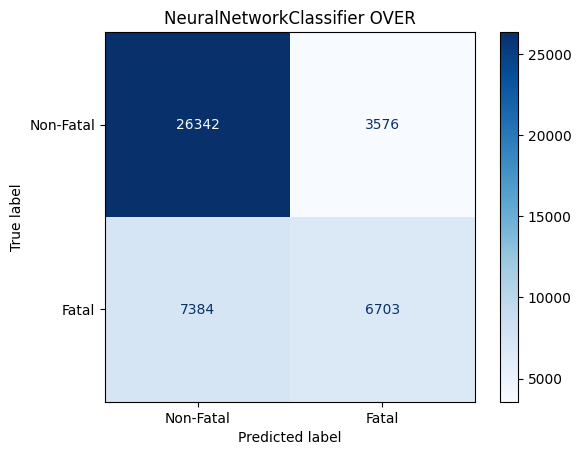

In [40]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_over_test,
    title=clf_name + ' OVER'
)

As theorized at the beginning, as much as the classifier achieves good performance predicting non-fatal examples, but for fatal examples it does not achieve positive performance because the number of false negatives exceeds the number of true negatives

from the ROC curves we note that still, as unhealthy as the results are not excellent, the classifier is better than a random prediction and achieves an AUC of 0.79

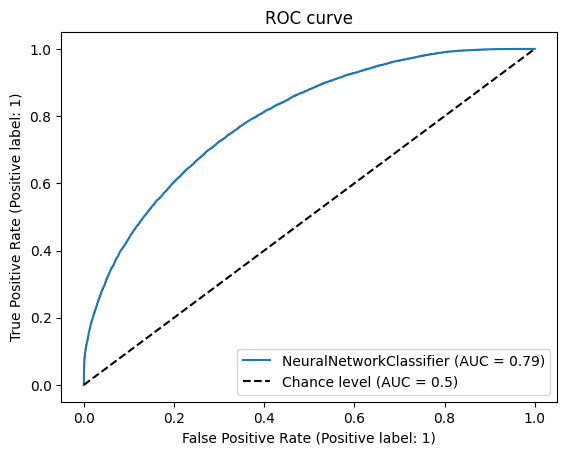

In [49]:
plot_roc(y_true=true_labels_test, y_probs=[pred_probas_over_test[:,1]], names=[clf_name])

From the following graphs we note that it is not possible to define specific situations in which a missprediction is performed, since they are uniformly distributed with respect to the various fetures used for prediction

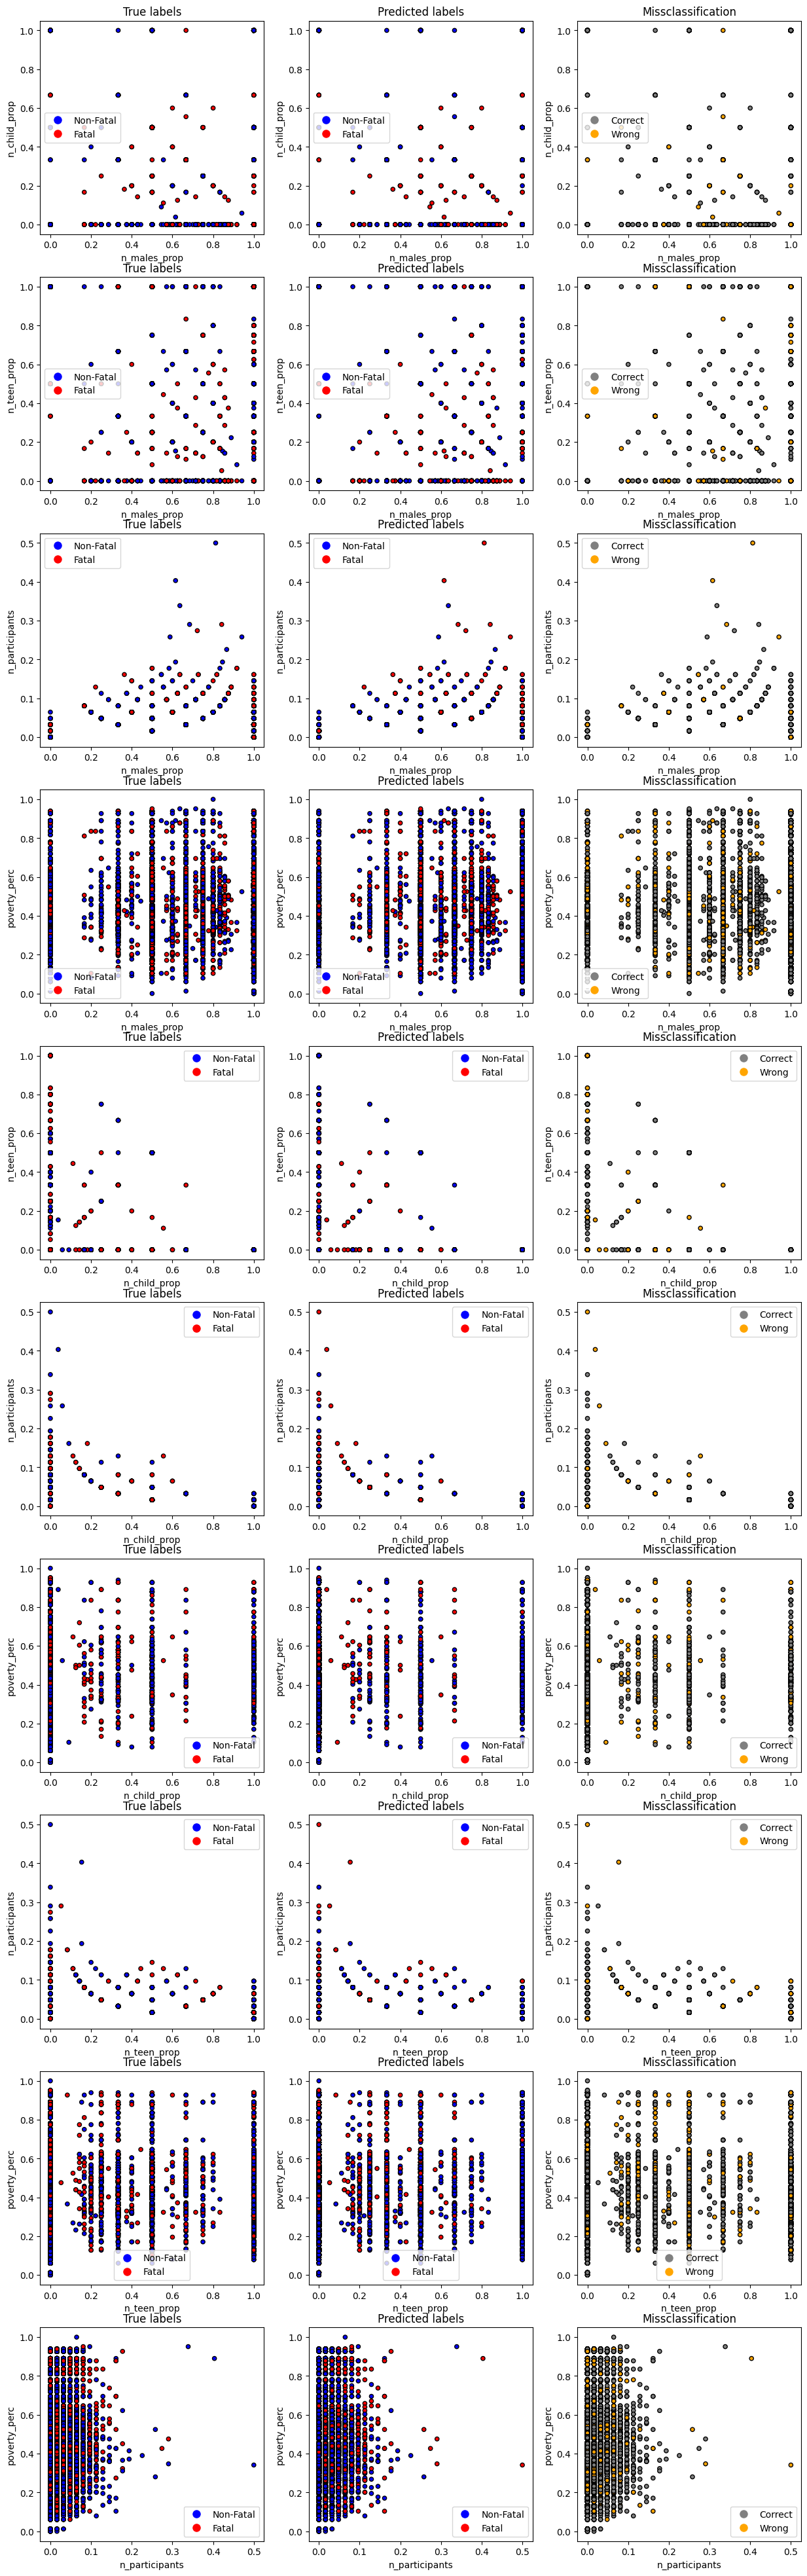

In [50]:
plot_predictions_in_features_space(
    df=incidents_test_df,
    features=['n_males_prop', 'n_child_prop', 'n_teen_prop', 'n_participants', 'poverty_perc'],
    true_labels=true_labels_test,
    pred_labels=pred_labels_test,
    figsize=(15, 50)
)

Once again we note how the classifier performs better in non-fatal accident cases, regardless of how many deaths were caused by the fatal accident

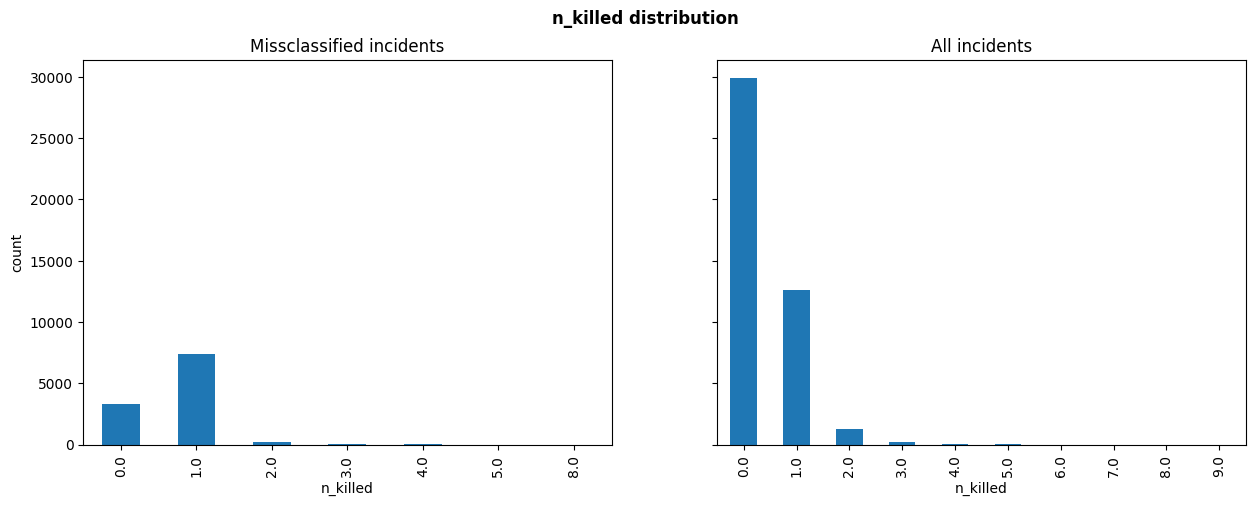

In [44]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'n_killed',
    'bar',
    title='n_killed distribution'
)

Instead, below we visualize how, in general, suicides are predicted effectively by the classifier, and we can note this from the difference in the proportion of suicides and non-suicides to total incidents and those incidents that are not correctly classified

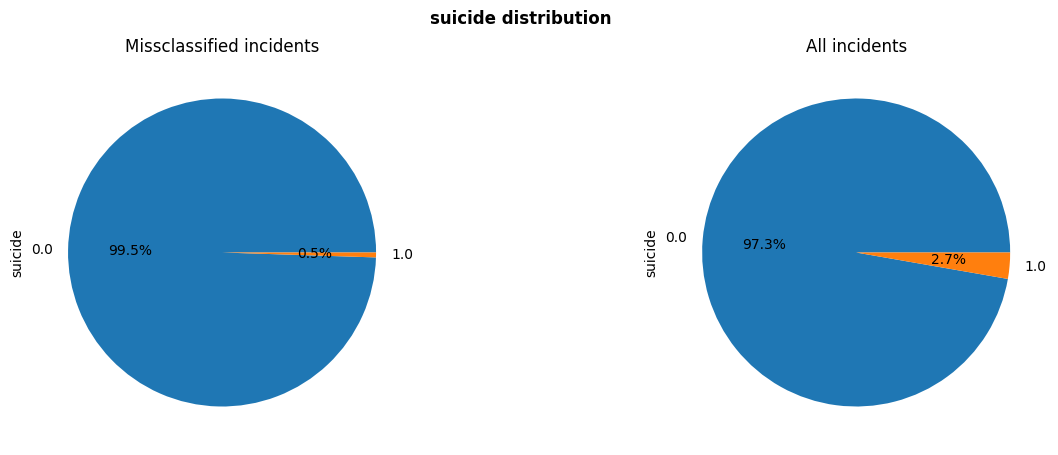

In [45]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'suicide',
    'pie',
    title='suicide distribution'
)

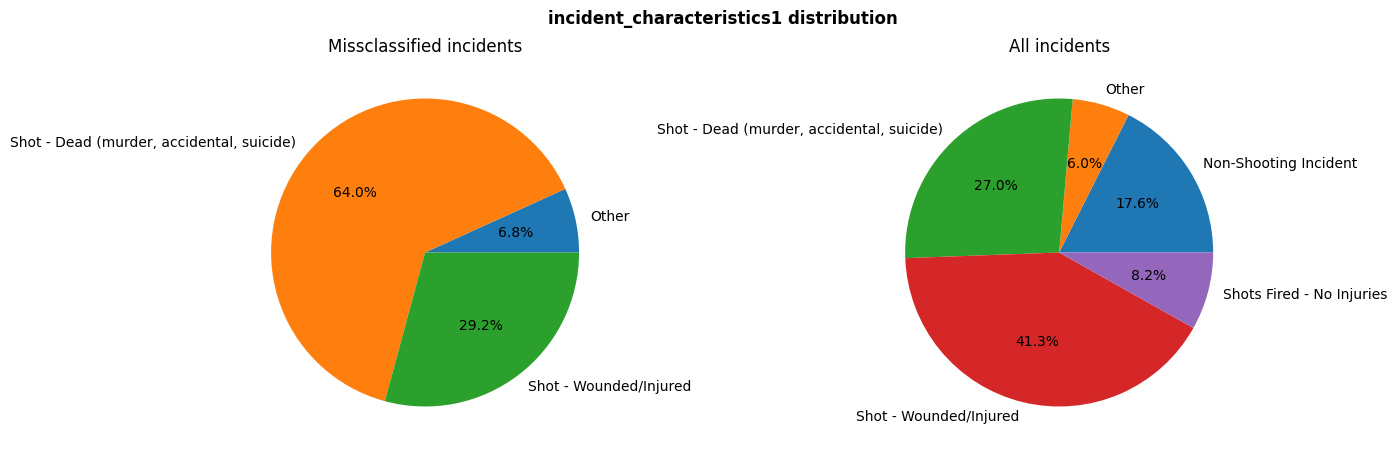

In [46]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics1',
    'pie',
    title='incident_characteristics1 distribution'
)

Finally, we note other graphs, in line with the previous one, showing the distribution of the various accident types of total accidents, compared to misclassified accidents

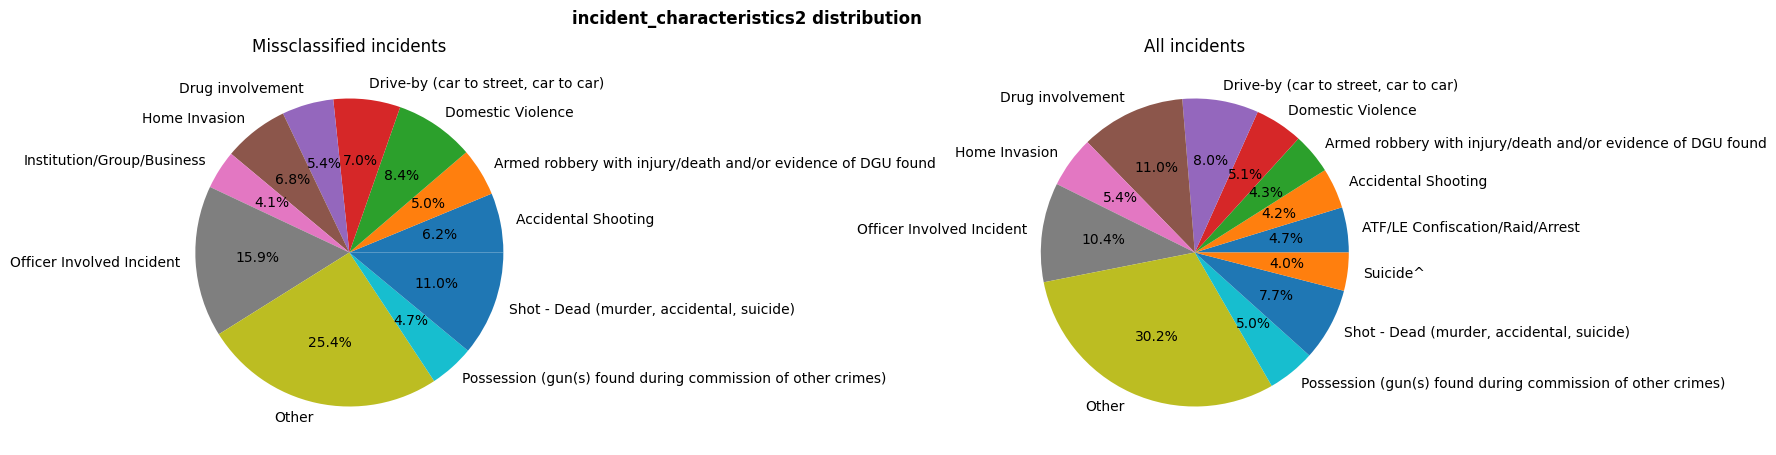

In [47]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics2',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5),
    title='incident_characteristics2 distribution'
)